# All

## Import

In [1]:
import json

import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import r_regression

In [2]:
data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"
bayesian_run_path = "../data/bayesian_runs/"


def read_file(filename, sub_folder="kaggle", delimiter=","):
    df = pd.read_csv(os.path.join(data_path, sub_folder, filename), delimiter=delimiter)

    if filename == "train.csv":
        df_revealed_test = read_file("revealed_test.csv")
        df = (
            pd.concat([df, df_revealed_test], axis=0)
            .sort_values(["cfips", "first_day_of_month"])
            .reset_index(drop=True)
        )
    return df


def fix_df_train_issues(df):
    # Fix weird county name which has weird symbols
    rr = df[
        (df["state_abb"] == "NM")
        & (df["county"].str.contains("ana county", case=False))
    ]
    rr = rr["county"].value_counts()
    assert rr.shape[0] == 1, "should only have one county here"
    df["county"] = df["county"].str.replace(rr.index[0], "Dona Ana County")

    return df


states_abb = {
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DC": "District of Columbia",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
}
states = {y: x for x, y in states_abb.items()}

In [3]:
df_train = read_file("train.csv")
df_train["state_abb"] = df_train.apply(lambda x: states[x["state"]], axis=1)
df_train['first_day_of_month'] = pd.to_datetime(df_train['first_day_of_month'])
df_train['year'] = df_train['first_day_of_month'].dt.year

df_train = fix_df_train_issues(df_train)

In [4]:
df_series_values = pd.read_csv('../data/other/df_series_values.csv')
df_series = pd.read_csv('../data/other/df_series.csv')

In [5]:
df_series_values = df_series_values.rename(columns={'value': 'population_x1000'})

In [6]:
idx = df_series[df_series['id'] == 'DCPOP'].index[0]
df_series.loc[idx, 'title'] = df_series.loc[idx, 'title'] + ' (state)'

In [7]:
df_series.loc[idx, 'title']

'Resident Population in the District of Columbia (state)'

In [8]:
df_series[df_series['id'] == 'AKPOP']

,id,title,frequency,id_estimate
74,AKPOP,Resident Population in Alaska,Annual,NaN


## Fred economic data

In [9]:
# api_key = "eb39e90a9fa1243b6f60c4b74e12e312"
# "https://fred.stlouisfed.org/docs/api/fred/#API"

In [10]:
from full_fred.fred import Fred
api_key = "eb39e90a9fa1243b6f60c4b74e12e312"

In [11]:
fred = Fred('fred_key.txt')
# fred.set_api_key_file('fred_key.txt')

In [12]:
fred.get_child_categories(0)

{'categories': [{'id': 32991,
   'name': 'Money, Banking, & Finance',
   'parent_id': 0},
  {'id': 10,
   'name': 'Population, Employment, & Labor Markets',
   'parent_id': 0},
  {'id': 32992, 'name': 'National Accounts', 'parent_id': 0},
  {'id': 1, 'name': 'Production & Business Activity', 'parent_id': 0},
  {'id': 32455, 'name': 'Prices', 'parent_id': 0},
  {'id': 32263, 'name': 'International Data', 'parent_id': 0},
  {'id': 3008, 'name': 'U.S. Regional Data', 'parent_id': 0},
  {'id': 33060, 'name': 'Academic Data', 'parent_id': 0}]}

In [13]:
def get_child_categories(obj, res, all_obj):
    all_obj.append(obj)
    # if 'categories' in obj
    for child_obj in obj['categories']:
        res.append(child_obj)
        api_response = fred.get_child_categories(child_obj['id'])
        if 'error_code' in api_response:
            while 'error_code' in api_response:
                print('Hit error code', api_response)
                time.sleep(30)
                api_response = fred.get_child_categories(child_obj['id'])
        get_child_categories(api_response, res, all_obj)

In [14]:
# res = []
# all_obj = []
# get_child_categories(fred.get_child_categories(0), res, all_obj)

In [15]:
# df_categories = pd.DataFrame(res)
# df_categories.shape

In [16]:
# df_categories.to_csv('../data/other/df_categories.csv')

#### df_series

In [17]:
# _temp = []
# for state_abb in df_train['state_abb'].unique():
#     id_contains = ["{}*POP".format(state_abb)]
#     t0 = fred.search_for_series(
#         id_contains, search_type="series_id", order_by="title", sort_order="asc"
#     )
#     t = pd.DataFrame(t0['seriess'])[['id', 'title', 'frequency']]
#     t['state_abb'] = state_abb
#     _temp.append(pd.DataFrame(t0['seriess'])[['id', 'title', 'frequency']])
# df_series = pd.concat(_temp, axis=0).reset_index(drop=True)
# df_series.to_csv('../data/other/df_series.csv', index=False)

In [18]:
# manual_additions = [
#     {
#         "id": "AKXXX01POP",
#         "id_estimate": "B03002001E002105",
#         "title": "MANUALLY ADDED ESTIMATE Hoonah-Angoon Census Area, AK",
#         "frequency": "Annual",
#     },
#     {
#         "id": "ILXXXPOP",
#         "id_estimate": "B03002001E017099",
#         "title": "MANUALLY ADDED ESTIMATE LaSalle County, IL",
#         "frequency": "Annual",
#     },
#     {
#         "id": "AKXXX02POP",
#         "id_estimate": "B03002001E002195",
#         "title": "MANUALLY ADDED ESTIMATE Petersburg Census Area, AK",
#         "frequency": "Annual",
#     },
# ]
# df_series = pd.read_csv("../data/other/df_series.csv")
# df_series = pd.concat([df_series, pd.DataFrame(manual_additions)]).reset_index(
#     drop=True
# )
# df_series.to_csv('../data/other/df_series.csv', index=False)

#### df_series_values

In [19]:
def get_series(_id):
    s = "2015-01-01"
    e = "9999-12-31"
    eo = "2025-02-24"
    
    t= None
    try:
        t = fred.get_series_df(_id, s, e, observation_start=s, observation_end=eo)
    except KeyError:
        time.sleep(30)
        t = get_series(_id)
    finally:
        return t

# _temp = []
# for idx, row in df_series.iterrows():
#     t = get_series(row['id'])
#     t['id'] = row['id']
#     _temp.append(t)
#     print(idx)
# df_series_values = pd.concat(_temp).reset_index(drop=True)
# df_series_values.to_csv('../data/other/df_series_values.csv', index=False)

In [20]:
# _temp = []
# for idx, row in df_series[~df_series["id_estimate"].isna()].iterrows():
#     _id = row["id"] if row["id_estimate"] is np.NaN else row["id_estimate"]
#     t = get_series(_id)
#     t["id"] = row["id"]
#     _temp.append(t)
#     print(idx)
# df_series_values = pd.read_csv("../data/other/df_series_values.csv")
# df_series_values = pd.concat([df_series_values, pd.concat(_temp)]).reset_index(
#     drop=True
# )
## Estimate values are not x1000 by default
# estimates = df_series_values[df_series_values['id'].str.contains('XXX')]
# df_series_values.loc[estimates.index, 'value'] = estimates['value'] / 1000
# df_series_values.to_csv('../data/other/df_series_values.csv', index=False)

In [21]:
df_series_values_f = df_series_values.sort_values(
    ["id", "realtime_end"], ascending=[True, False]
).drop_duplicates(["id", "date"])
df_series_values_f = df_series_values_f.sort_values(["id", "date"]).reset_index(
    drop=True
)

### Join train with fred population data

In [22]:
t_joined = pd.merge(
    df_series_values_f.sort_values(
        ["id", "realtime_end"], ascending=[True, False]
    ).drop_duplicates(["id", "date"]),
    df_series,
    "left",
    "id",
)

t1 = t_joined.apply(
    lambda x: x["title"]
    .lower()
    .replace("resident population in ", "")
    .replace("/city", "")
    .replace("borough/", "")
    .replace("sitka borough", "sitka city and borough")
    .replace("juneau borough", "juneau city and borough")
    .replace("/town", "")
    .replace("elliot ", "elliott ")
    .replace("mccreary,", "mccreary county,")
    .replace("debaca county", "de baca county")
    .replace("de soto county, ms", "desoto county, ms")
    .replace("the district of columbia", "district of columbia")
    .replace("la salle parish", "lasalle parish")
    .replace("manually added estimate ", "")
    .replace("petersburg census area", "petersburg borough")
    .split(","),
    axis=1,
)

t_joined[["county", "state_abb"]] = pd.DataFrame(
    t1.tolist(), index=t1.index, columns=["county", "state_abb"]
)
t_joined["state_abb"] = t_joined["id"].str[:2].str.upper()
# t_joined["state_abb"] = t_joined["id"].str[:2].str.lower()

t_joined["county"] = t_joined["county"].str.lower()
t_joined["state_abb"] = t_joined["state_abb"].str.lstrip()
t_joined = t_joined.rename(
    columns={"date": "population_date", "value": "population_x1000"}
)
t_joined["population_date"] = pd.to_datetime(t_joined["population_date"])

t_joined["year"] = t_joined["population_date"].dt.year

t_train = df_train.copy()
t_train["county"] = t_train["county"].str.lower()
t_train["state_abb"] = t_train["state_abb"]
# t_train["state_abb"] = t_train["state_abb"].str.lower()

df_train_series = pd.merge(
    t_train, t_joined, "left", ["state_abb", "county", "year"], indicator=False
).drop(
    columns=[
        "realtime_start",
        "realtime_end",
        "frequency",
        # "title",
        "population_date",
        "population_x1000",
    ]
)

# Both these IDs have population for whole state, instead of county.
# df_train_series = df_train_series[
#     ~(df_train_series["id"].isin(["DCDIST5POP", "DCPOP"]))
# ].reset_index(drop=True)

# df_train_series = df_train_series[
#     ~(df_train_series["id"].isin(["DCDIST5POP", "DCPOP"]))
# ].reset_index(drop=True)

In [23]:
df_train_series[
    (df_train_series["id"].isin(["DCDIST5POP", "DCPOP"]))
][['id', 'county', 'state', 'first_day_of_month']].sort_values(['first_day_of_month', 'id'])

,id,county,state,first_day_of_month
12997,DCDIST5POP,district of columbia,District of Columbia,2019-08-01
12998,DCDIST5POP,district of columbia,District of Columbia,2019-09-01
12999,DCDIST5POP,district of columbia,District of Columbia,2019-10-01
13000,DCDIST5POP,district of columbia,District of Columbia,2019-11-01
13001,DCDIST5POP,district of columbia,District of Columbia,2019-12-01
13002,DCDIST5POP,district of columbia,District of Columbia,2020-01-01
13003,DCDIST5POP,district of columbia,District of Columbia,2020-02-01
13004,DCDIST5POP,district of columbia,District of Columbia,2020-03-01
13005,DCDIST5POP,district of columbia,District of Columbia,2020-04-01
13006,DCDIST5POP,district of columbia,District of Columbia,2020-05-01


In [24]:
df_train_series.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'state_abb', 'year', 'id', 'title',
       'id_estimate'],
      dtype='object')

In [25]:
df_train_series[df_train_series['id'].isna()]['year'].value_counts()

2022    37620
Name: year, dtype: int64

In [26]:
# df_train_series[~df_train_series['population_x1000'].isna()].head()

In [27]:
df_train_series[~df_train_series['id_estimate'].isna()].head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,state_abb,year,id,title,id_estimate
3116,2105_2019-08-01,2105,hoonah-angoon census area,Alaska,2019-08-01,5.567929,100,AK,2019,AKXXX01POP,MANUALLY ADDED ESTIMATE Hoonah-Angoon Census A...,B03002001E002105
3117,2105_2019-09-01,2105,hoonah-angoon census area,Alaska,2019-09-01,5.567929,100,AK,2019,AKXXX01POP,MANUALLY ADDED ESTIMATE Hoonah-Angoon Census A...,B03002001E002105
3118,2105_2019-10-01,2105,hoonah-angoon census area,Alaska,2019-10-01,5.623608,101,AK,2019,AKXXX01POP,MANUALLY ADDED ESTIMATE Hoonah-Angoon Census A...,B03002001E002105


In [28]:
df_series_values_f[df_series_values_f['id'] == 'DEPOP']

,realtime_start,realtime_end,date,population_x1000,id
2379,2020-12-22,9999-12-31,2015-01-01,942.065,DEPOP
2380,2020-12-22,9999-12-31,2016-01-01,949.989,DEPOP
2381,2020-12-22,9999-12-31,2017-01-01,957.942,DEPOP
2382,2020-12-22,9999-12-31,2018-01-01,966.985,DEPOP
2383,2020-12-22,9999-12-31,2019-01-01,976.668,DEPOP
2384,2022-12-22,9999-12-31,2020-01-01,992.114,DEPOP
2385,2022-12-22,9999-12-31,2021-01-01,1004.807,DEPOP
2386,2022-12-22,9999-12-31,2022-01-01,1018.396,DEPOP


In [29]:
df_series[df_series['id'] == 'DCPOP']

,id,title,frequency,id_estimate
338,DCPOP,Resident Population in the District of Columbi...,Annual,NaN


In [30]:
df_series[df_series['id'] == 'DCDIST5POP']

,id,title,frequency,id_estimate
339,DCDIST5POP,Resident Population in the District of Columbia,Annual,NaN


In [31]:
df_train_series[df_train_series['state'] == 'District of Columbia']['id'].value_counts()

DCDIST5POP    29
Name: id, dtype: int64

### Predict 2022

In [32]:
# Add year 2022
t1 = pd.DataFrame.from_dict({"id": df_series_values_f["id"].unique()})
manual_date = "1970-01-01"
t1["realtime_start"] = manual_date
t1["realtime_end"] = manual_date
t1["date"] = "2022-01-01"
t1["population_x1000"] = np.nan
t1 = (
    pd.concat([df_series_values_f, t1])
    .sort_values(["id", "date"])
    .reset_index(drop=True)
)

# Add MA etc
t1["value_pct_change"] = t1.groupby("id")["population_x1000"].pct_change(limit=0)

t1["ma2_value_pct_change"] = (
    t1.groupby("id")["value_pct_change"]
    .rolling(window=2, min_periods=2)
    .mean()
    .reset_index(drop=True)
)

# Add "id", "county", "state", "state_abb"
t1 = pd.merge(
    t1,
    df_train_series[["id", "county", "state", "state_abb"]]
    .drop_duplicates()
    .reset_index(drop=True),
    "left",
    "id",
)

# Separate only year 2022 and make prediction
t2 = t1[~((~t1["population_x1000"].isna()) & (t1["ma2_value_pct_change"].isna()))].copy()
t2[
    ["population_x1000", "value_pct_change", "ma2_value_pct_change"]
] = t2[
    ["population_x1000", "value_pct_change", "ma2_value_pct_change"]
].fillna(method="ffill")
t2["year"] = pd.to_datetime(t2["date"]).dt.year
df_2022 = (t2[t2["date"] == "2022-01-01"].copy()).rename(columns={'population_x1000': 'population_x1000_prev_year'})
df_2022["predicted_population_x1000"] = df_2022["population_x1000_prev_year"] * (
    1 + df_2022["ma2_value_pct_change"]
)

df_other_years = t2[~(t2["date"] == "2022-01-01")].copy()

df_2022.head(3)

,realtime_start,realtime_end,date,population_x1000_prev_year,id,value_pct_change,ma2_value_pct_change,county,state,state_abb,year,predicted_population_x1000
7,1970-01-01,1970-01-01,2022-01-01,5.059,AKALEU0POP,-0.028237,-0.057612,aleutians west census area,Alaska,AK,2022,4.767542
15,1970-01-01,1970-01-01,2022-01-01,3.398,AKALEU3POP,-0.005851,0.006463,aleutians east borough,Alaska,AK,2022,3.419962
23,1970-01-01,1970-01-01,2022-01-01,288.121,AKANCH0POP,-0.008657,-0.001131,anchorage municipality,Alaska,AK,2022,287.795251


In [33]:
df_other_years

,realtime_start,realtime_end,date,population_x1000,id,value_pct_change,ma2_value_pct_change,county,state,state_abb,year
2,2021-05-04,9999-12-31,2017-01-01,5.760,AKALEU0POP,0.007345,-0.001862,aleutians west census area,Alaska,AK,2017
3,2021-05-04,9999-12-31,2018-01-01,5.678,AKALEU0POP,-0.014236,-0.003445,aleutians west census area,Alaska,AK,2018
4,2021-05-04,9999-12-31,2019-01-01,5.702,AKALEU0POP,0.004227,-0.005005,aleutians west census area,Alaska,AK,2019
5,2022-03-24,9999-12-31,2020-01-01,5.206,AKALEU0POP,-0.086987,-0.041380,aleutians west census area,Alaska,AK,2020
6,2022-03-24,9999-12-31,2021-01-01,5.059,AKALEU0POP,-0.028237,-0.057612,aleutians west census area,Alaska,AK,2021
...,...,...,...,...,...,...,...,...,...,...,...
26045,2021-05-04,9999-12-31,2017-01-01,6.962,WYWEST5POP,-0.036801,-0.016596,weston county,Wyoming,WY,2017
26046,2021-05-04,9999-12-31,2018-01-01,6.895,WYWEST5POP,-0.009624,-0.023212,weston county,Wyoming,WY,2018
26047,2021-05-04,9999-12-31,2019-01-01,6.880,WYWEST5POP,-0.002175,-0.005900,weston county,Wyoming,WY,2019
26048,2022-03-24,9999-12-31,2020-01-01,6.809,WYWEST5POP,-0.010320,-0.006248,weston county,Wyoming,WY,2020


In [34]:
cols = ["id", "year", "state", "county", "state_abb", 'population_x1000']

t_2022 = df_2022.rename(columns={"predicted_population_x1000": "population_x1000"})[
    cols
]

t_other_years = df_other_years[cols]

# Save results

In [62]:
t = pd.concat([t_2022, t_other_years])[['year', 'state', 'county', 'population_x1000']]
t['year'] = t['year'] + 2
t_train = df_train.copy()
t_train['county'] = t_train['county'].str.lower()
t2 = pd.merge(t_train, t, "left", ["year", "state", "county"])[
    ["row_id", "population_x1000"]
]
assert t2[t2['population_x1000'].isna()].shape[0] == 0, 'has to be 0'
t2.to_csv('../data/other/df_population.csv', index=False)

#### Compare state level populations

In [39]:
df_state_pop_source = (
    df_series_values_f[df_series_values_f["id"].apply(len) == 5].copy().dropna()
)
df_state_pop_source["state_abb"] = df_state_pop_source["id"].str[:2]
df_state_pop_source["state"] = df_state_pop_source.apply(
    lambda x: states_abb[x["state_abb"]], axis=1
)
df_state_pop_source['year'] = pd.to_datetime(df_state_pop_source['date']).dt.year
# df_state_pop_source.head(9)

In [40]:
df_pop_other = (
    df_other_years.groupby(["state", "state_abb", "year"])["population_x1000"]
    .sum()
    .rename("population_x1000_state_sum")
    .reset_index()
)
df_pop_other = pd.merge(
    df_pop_other,
    df_state_pop_source[["population_x1000", "state_abb", "state", "year", "id"]],
    "left",
    ["state_abb", "state", "year"],
)
df_pop_other["diff"] = abs(
    df_pop_other["population_x1000_state_sum"] - df_pop_other["population_x1000"]
)

<Axes: >

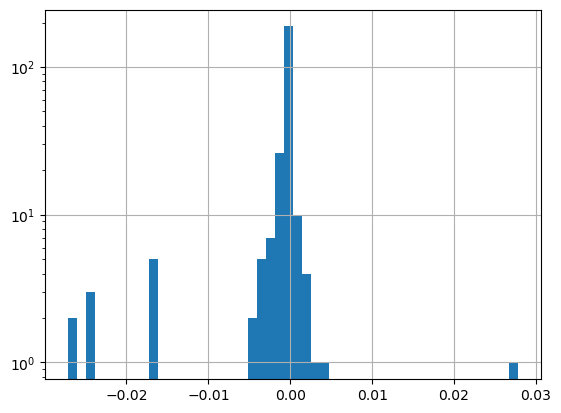

In [41]:
df_pop_other["population_pct_diff"] = 1 - (
    df_pop_other["population_x1000"] / df_pop_other["population_x1000_state_sum"]
)
df_pop_other.sort_values("population_pct_diff")["population_pct_diff"].hist(
    bins=50, log=True
)

In [42]:
df_pop_2022 = (
    df_2022.groupby(["state", "state_abb", "year"])["predicted_population_x1000"]
    .sum()
    .rename("predicted_population_x1000_state_sum")
    .reset_index()
)
df_pop_2022 = pd.merge(
    df_pop_2022,
    df_state_pop_source[["population_x1000", "state_abb", "state", "year", "id"]],
    "left",
    ["state_abb", "state", "year"],
)
df_pop_2022["diff"] = abs(
    df_pop_2022["predicted_population_x1000_state_sum"]
    - df_pop_2022["population_x1000"]
)

<Axes: >

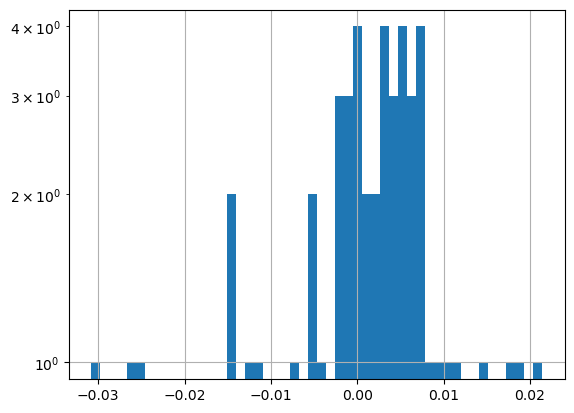

In [43]:
df_pop_2022["population_pct_diff"] = 1 - (
    df_pop_2022["population_x1000"] / df_pop_2022["predicted_population_x1000_state_sum"]
)

df_pop_2022.sort_values('population_pct_diff')['population_pct_diff'].hist(bins=50, log=True)

In [53]:
df_pop_2022.sort_values('population_pct_diff')

,state,state_abb,year,predicted_population_x1000_state_sum,population_x1000,id,diff,population_pct_diff
8,District of Columbia,DC,2022,651.729337,671.803,DCPOP,20.073663,-0.030801
1,Alaska,AK,2022,714.669984,733.583,AKPOP,18.913016,-0.026464
41,South Dakota,SD,2022,887.269528,909.824,SDPOP,22.554472,-0.025420
40,South Carolina,SC,2022,5209.075759,5282.634,SCPOP,73.558241,-0.014121
9,Florida,FL,2022,21935.666342,22244.823,FLPOP,309.156658,-0.014094
2,Arizona,AZ,2022,7270.985237,7359.197,AZPOP,88.211763,-0.012132
33,North Carolina,NC,2022,10582.886386,10698.973,NCPOP,116.086614,-0.010969
43,Texas,TX,2022,29820.083950,30029.572,TXPOP,209.488050,-0.007025
3,Arkansas,AR,2022,3029.762977,3045.637,ARPOP,15.874023,-0.005239
50,Wyoming,WY,2022,578.351884,581.381,WYPOP,3.029116,-0.005237
